## MARBL diagnostics for vertical and horizontal nutrient distribution for ocean history files: 

### case 001 x1 current config

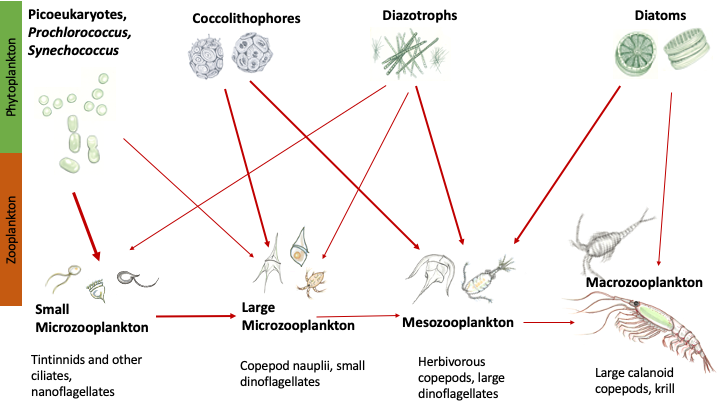

In [79]:
from IPython.display import Image
Image(filename='/glade/u/home/kristenk/adding_zooplankton/MARBL_4p4z/images/just_food_web.png')

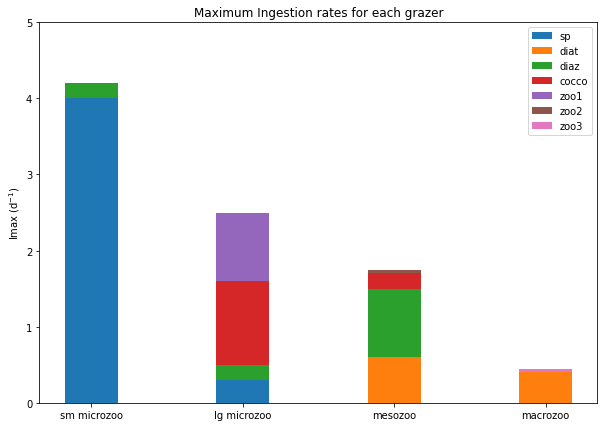

In [144]:
N = 4 # number of grazers

#grazees
sp = [4, 0.3, 0, 0]
diat = [0, 0, 0.6, 0.4]
diaz = [0.2, 0.2, 0.9, 0]
cocco = [0, 1.1, 0.2, 0]
zoo1 = [0,0.9,0,0]
zoo2 = [0,0,0.04,0]
zoo3 = [0,0,0,0.05]

ind = np.arange(N)    # the x locations for the grazers
width = 0.35       # the width of the bars

bars2=np.add(sp, diat).tolist()
bars3=np.add(bars2, diaz).tolist()
bars4=np.add(bars3, cocco).tolist()
bars5=np.add(bars4, zoo1).tolist()
bars6=np.add(bars5, zoo2).tolist()

p1 = plt.bar(ind, sp, width)
p2 = plt.bar(ind, diat, width, bottom=sp)
p3 = plt.bar(ind, diaz, width, bottom=bars2)
p4 = plt.bar(ind, cocco, width, bottom=bars3)
p5 = plt.bar(ind, zoo1, width, bottom=bars4)
p6 = plt.bar(ind, zoo2, width, bottom=bars5)
p7 = plt.bar(ind, zoo3, width, bottom=bars6)

plt.rcParams["figure.figsize"] = (10,7)
plt.ylabel('Imax (d$^{-1}$)')
plt.title('Maximum Ingestion rates for each grazer')
plt.xticks(ind, ('sm microzoo', 'lg microzoo', 'mesozoo', 'macrozoo'))
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0], p7[0]), ('sp', 'diat', 'diaz', 'cocco','zoo1','zoo2','zoo3'))
plt.ylim(0,5);

In [81]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
from cartopy.util import add_cyclic_point

### Define latest years and get the CESM data

In [82]:
start_yr = 59
num_years = 2
endyr = start_yr + num_years 
case = 'g.e22a06.G1850ECOIAF.T62_g17.4p4z.001'
user = 'kristenk'

In [83]:
files = []
for year in range(start_yr,endyr):
    yr4="{:04d}".format(year)
    print('doing simulation year', year, '!')
    for month in range(1, 13):
    
        mo2="{:02d}".format(month)
        files.extend(sorted(glob(f'/glade/scratch/{user}/archive/{case}/ocn/hist/{case}.pop.h.{yr4}-{mo2}.nc')))
        #files.extend(sorted(glob(f'/glade/scratch/{user}/{case}/run/{case}.pop.h.{yr4}-{mo2}.nc')))

doing simulation year 59 !
doing simulation year 60 !


In [84]:
cesm_mon_ds=xr.open_mfdataset(files,decode_times=False,decode_coords=False, concat_dim='time')

### Keep only the variables we need

In [85]:
variables = ['sp_Fe_lim_surf','sp_P_lim_surf','sp_N_lim_surf',
             'diat_Fe_lim_surf', 'diat_P_lim_surf','diat_N_lim_surf',
             'diat_SiO3_lim_surf','diaz_P_lim_surf',
             'diaz_Fe_lim_surf','photoC_TOT_zint','photoC_sp_zint',
             'photoC_diat_zint','photoC_diaz_zint','photoC_cocco_zint',
             'cocco_Fe_lim_surf','cocco_C_lim_surf','cocco_N_lim_surf',
             'cocco_P_lim_surf','CaCO3_PROD_zint','SiO2_PROD','POC_FLUX_100m',
             'coccoCaCO3','diatC', 'coccoC','spC','diazC','ALK','SALT',
             'PO4','Fe','NO3','SiO3','ALK',
            'zoo1C','zoo2C','zoo3C','zoo4C','x_graze_zoo1_zint','x_graze_zoo2_zint',
            'x_graze_zoo3_zint','x_graze_zoo4_zint','IFRAC'] 
coords = {'x':'TLONG','y':'TLAT'}

In [86]:
keepthese=['z_t','z_t_150m','time_bound','TAREA','REGION_MASK'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']
cesm_mon_ds = cesm_mon_ds.drop([v for v in cesm_mon_ds.variables if v not in keep_vars])

In [87]:
cesm_ann_ds=cesm_mon_ds.mean(dim='time')

#### World Ocean Atlas 2013

In [88]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2018_POPgrid.nc' 
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)

In [89]:
ds_woa['z_t'] = cesm_ann_ds.z_t

In [90]:
NO3_diff = cesm_ann_ds.NO3 - ds_woa.NO3
PO4_diff = cesm_ann_ds.PO4 - ds_woa.PO4
SiO3_diff = cesm_ann_ds.SiO3 - ds_woa.SiO3

In [91]:
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA
depths=ds_woa.z_t * 0.01
area_m=area * 1.e-4
dz_m=ds_woa.dz * 0.01

In [92]:
rmse_global = xr.Dataset({v: cesm_ann_ds[v] for v in ['z_t']})

In [93]:
#help(esmlab.statistics)
rmse_global['NO3']=esmlab.statistics.weighted_rmsd(cesm_ann_ds.NO3, ds_woa.NO3, dim=['nlat', 'nlon'], weights=area)
rmse_global['PO4']=esmlab.statistics.weighted_rmsd(cesm_ann_ds.PO4, ds_woa.PO4, dim=['nlat', 'nlon'], weights=area)
rmse_global['SiO3']=esmlab.statistics.weighted_rmsd(cesm_ann_ds.SiO3, ds_woa.SiO3, dim=['nlat', 'nlon'], weights=area)

In [94]:
rmse_global.PO4.values

array([0.21662148, 0.22400931, 0.23763879, 0.24944066, 0.25909135,
       0.26656172, 0.27380763, 0.28070316, 0.28795877, 0.29577902,
       0.3003462 , 0.30262282, 0.30678223, 0.30323314, 0.30064371,
       0.29337097, 0.28344305, 0.27793035, 0.27109391, 0.26890023,
       0.25919383, 0.25798637, 0.24809637, 0.24119221, 0.23853543,
       0.23778671, 0.23861273, 0.24001474, 0.23947867, 0.23991162,
       0.24004714, 0.23568747, 0.22999187, 0.22090588, 0.21318237,
       0.20080618, 0.19303992, 0.18004988, 0.16351994, 0.16025596,
       0.15881526, 0.16373295, 0.1709309 , 0.16129015, 0.15145425,
       0.137724  , 0.12991581, 0.12038684, 0.11037923, 0.10600815,
       0.10285982, 0.10093757, 0.09771327, 0.08928386, 0.08069137,
       0.08033282, 0.08318727, 0.08632441, 0.08098393, 0.06745262])

In [95]:
rmse_global.NO3.values

array([2.03981331, 2.07932435, 2.26257072, 2.47320593, 2.65139472,
       2.77958663, 2.93771223, 3.12477479, 3.30768744, 3.48955772,
       3.58954544, 3.69516404, 3.8590449 , 3.92320912, 4.02624438,
       4.09375861, 4.1455196 , 4.25316008, 4.29023335, 4.38685789,
       4.49554519, 4.68464433, 4.77134132, 4.94008761, 5.2065775 ,
       5.51178835, 5.85719493, 6.1995017 , 6.45092387, 6.70638491,
       6.86580384, 6.95108124, 6.9625896 , 6.99367148, 6.94987679,
       6.64299813, 6.12944953, 5.31833596, 4.37026162, 3.54785088,
       2.69309313, 2.34380008, 2.36639027, 2.46111799, 2.45444408,
       2.29364317, 2.01300734, 1.71572641, 1.47326855, 1.33762681,
       1.28237275, 1.27498928, 1.2251575 , 1.09932358, 0.95896518,
       0.94647927, 0.90559319, 0.90358791, 0.86282617, 0.90670499])

In [96]:
rmse_global.SiO3.values

array([6.7501801 , 6.90517571, 6.87355861, 6.86006979, 6.87366065,
       6.90626186, 7.11527573, 7.29803914, 7.62210975, 7.88281468,
       8.15300386, 8.47364631, 8.75709949, 8.86558333, 8.88629744,
       8.78823424, 8.63617988, 8.53793184, 8.35889217, 8.29000994,
       8.11535406, 8.02885914, 7.85488284, 7.77789479, 7.73919223,
       7.70488356, 7.71966097, 7.79894686, 7.73591819, 7.83220959,
       8.07588332, 8.3475048 , 8.57833183, 8.90647356, 9.33970247,
       9.64840919, 9.7517756 , 9.45221557, 9.02797508, 8.5104283 ,
       7.47437602, 6.63269585, 6.23672828, 6.04267039, 6.18750366,
       6.51572759, 7.18081647, 7.68341081, 8.17503215, 8.57586287,
       8.93075434, 9.24539389, 9.21966242, 8.72279418, 8.29299948,
       8.67539779, 9.33216633, 9.79047784, 8.40253905, 7.253385  ])

#### Surface nutrients

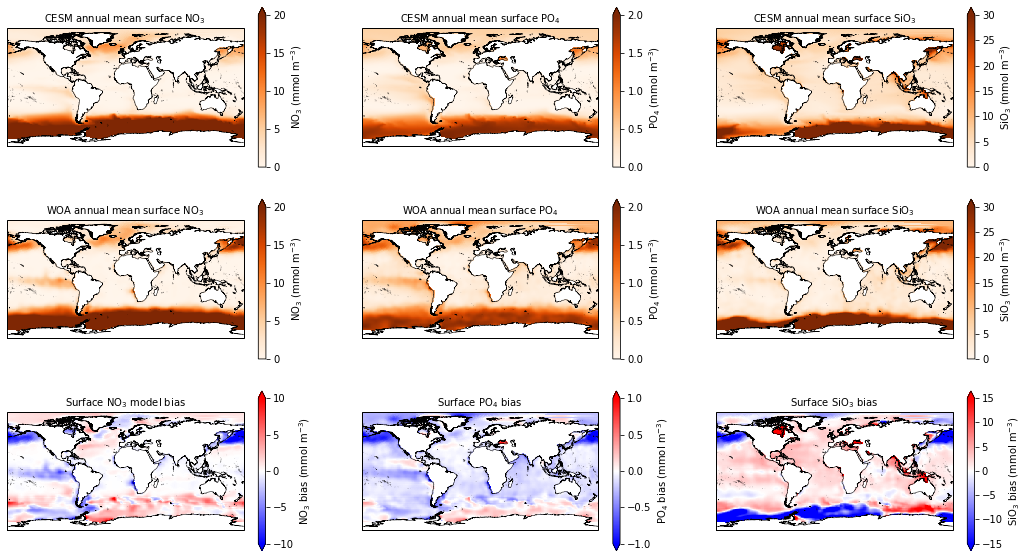

In [97]:
fig = plt.figure(figsize=(18,10))

####################NO3
#COLUMN 1  - NO3
#---- CESM panel
ax = fig.add_subplot(3,3,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface NO$_3$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 cesm_ann_ds.NO3.isel(z_t=0), vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,4, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface NO$_3$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.NO3.isel(z_t=0), vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,7, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface NO$_3$ model bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 NO3_diff.isel(z_t=0), vmin=-10, vmax=10, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='NO$_3$ bias (mmol m$^{-3}$)')



####################PO4
#---- CESM panel
ax = fig.add_subplot(3,3,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface PO$_4$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 cesm_ann_ds.PO4.isel(z_t=0), vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,5, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface PO$_4$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.PO4.isel(z_t=0), vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,8, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface PO$_4$ bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 PO4_diff.isel(z_t=0), vmin=-1, vmax=1, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='PO$_4$ bias (mmol m$^{-3}$)')



####################SiO3
#---- CESM panel
ax = fig.add_subplot(3,3,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface SiO$_3$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 cesm_ann_ds.SiO3.isel(z_t=0), 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,6, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface SiO$_3$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.SiO3.isel(z_t=0), 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,9, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface SiO$_3$ bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 SiO3_diff.isel(z_t=0), 
                  vmin=-15, vmax=15, 
                  cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='SiO$_3$ bias (mmol m$^{-3}$)')



### Global nutrient profiles

In [98]:
ds_glb = xr.Dataset({v: cesm_ann_ds[v] for v in ['z_t']})
ds_glb['NO3']= esmlab.weighted_mean(cesm_ann_ds['NO3'], weights=area, dim=['nlat', 'nlon']).compute()
ds_glb['PO4']= esmlab.weighted_mean(cesm_ann_ds['PO4'], weights=area, dim=['nlat', 'nlon']).compute()
ds_glb['SiO3']= esmlab.weighted_mean(cesm_ann_ds['SiO3'], weights=area, dim=['nlat', 'nlon']).compute()

In [99]:
ds_glb_woa = xr.Dataset({v: cesm_ann_ds[v] for v in ['z_t']})
ds_glb_woa['NO3'] = esmlab.weighted_mean(ds_woa['NO3'], weights=area, dim=['nlat', 'nlon']).compute()
ds_glb_woa['PO4'] = esmlab.weighted_mean(ds_woa['PO4'], weights=area, dim=['nlat', 'nlon']).compute()
ds_glb_woa['SiO3'] = esmlab.weighted_mean(ds_woa['SiO3'], weights=area, dim=['nlat', 'nlon']).compute()

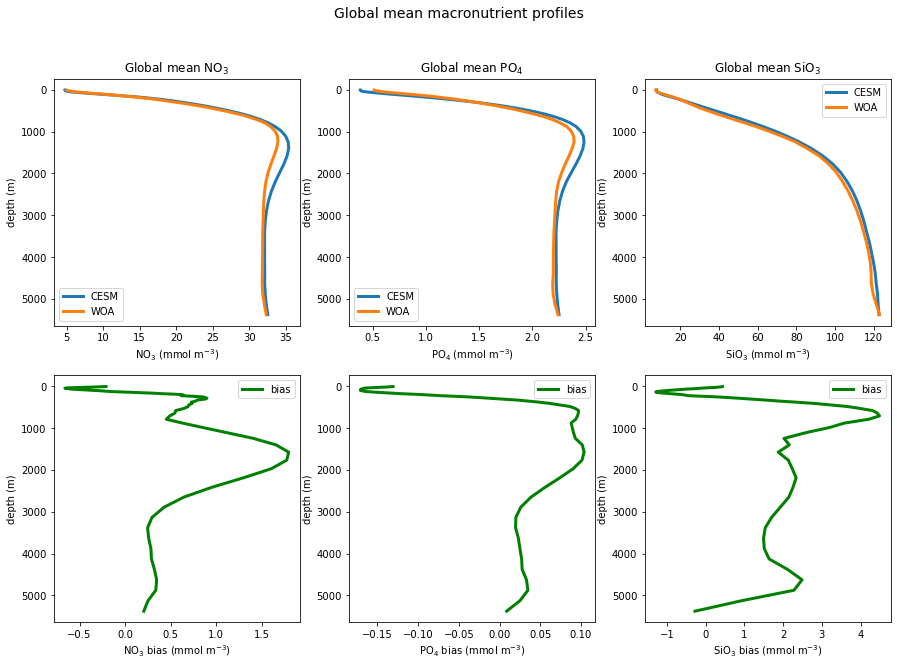

In [100]:
fig = plt.figure(figsize=(15,10))

plt.suptitle('Global mean macronutrient profiles', fontsize=14)


#COLUMN 1  - NO3

ax = fig.add_subplot(2,3,1)
ax.set_title('Global mean NO$_3$')
ax.plot(ds_glb['NO3'].values, depths, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['NO3'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4

ax = fig.add_subplot(2,3,2)
ax.set_title('Global mean PO$_4$')
ax.plot(ds_glb['PO4'].values, depths, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['PO4'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3

ax = fig.add_subplot(2,3,3)
ax.set_title('Global mean SiO$_3$')
ax.plot(ds_glb['SiO3'].values, depths, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['SiO3'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()


#COLUMN 1  - NO3 diff

ax = fig.add_subplot(2,3,4)
ax.plot(ds_glb['NO3'].values - ds_glb_woa['NO3'].values, depths, label='bias', linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4 diff

ax = fig.add_subplot(2,3,5)
ax.plot(ds_glb['PO4'].values - ds_glb_woa['PO4'].values, depths, label='bias', linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3 diff

ax = fig.add_subplot(2,3,6)
ax.plot(ds_glb['SiO3'].values - ds_glb_woa['SiO3'].values, depths, label='bias', linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()



### Phytoplankton nutrient limitation at surface

In [101]:
#most limiting nutrient - concatenate the limitation terms so that nutrient limitation terms are each along the 'nutrient' dimension
# 0 = PO4
# 1 = Fe
# 2 = NO3 (only for sp and diat)
# 3 = Si (only for diat)
# 3 = C (only for cocco)

limarray_sp=xr.concat((cesm_ann_ds.sp_P_lim_surf, cesm_ann_ds.sp_Fe_lim_surf,cesm_ann_ds.sp_N_lim_surf),dim='nutrient')
limarray_diat=xr.concat((cesm_ann_ds.diat_P_lim_surf, cesm_ann_ds.diat_Fe_lim_surf, cesm_ann_ds.diat_N_lim_surf, cesm_ann_ds.diat_SiO3_lim_surf),dim='nutrient')
limarray_diaz=xr.concat((cesm_ann_ds.diaz_P_lim_surf, cesm_ann_ds.diaz_Fe_lim_surf),dim='nutrient')
limarray_cocco=xr.concat((cesm_ann_ds.cocco_P_lim_surf, cesm_ann_ds.cocco_Fe_lim_surf, cesm_ann_ds.cocco_N_lim_surf, cesm_ann_ds.cocco_C_lim_surf),dim='nutrient')

In [102]:
most_lim_sp=limarray_sp.argmin(dim='nutrient', skipna=False)
most_lim_diat=limarray_diat.argmin(dim='nutrient', skipna=False)
most_lim_diaz=limarray_diaz.argmin(dim='nutrient', skipna=False)
most_lim_cocco=limarray_cocco.argmin(dim='nutrient', skipna=False)
mask = np.isnan(cesm_ann_ds.sp_N_lim_surf.squeeze())

In [103]:
most_lim_sp = most_lim_sp.squeeze()
most_lim_diat = most_lim_diat.squeeze()
most_lim_diaz = most_lim_diaz.squeeze()
most_lim_cocco = most_lim_cocco.squeeze()

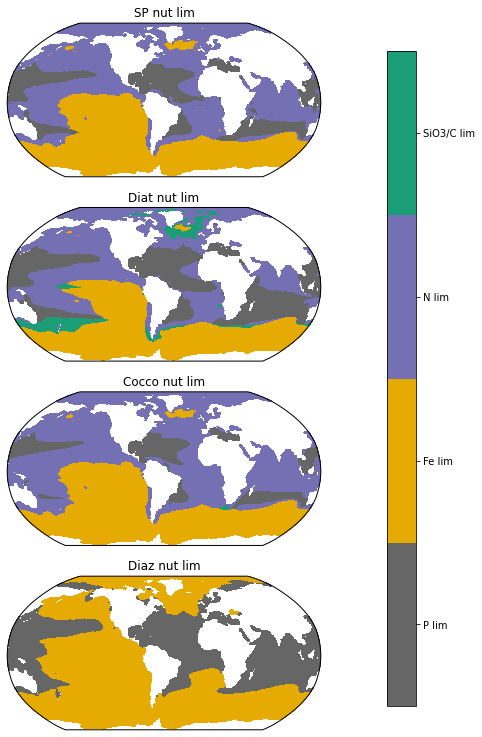

In [104]:
fig = plt.figure(figsize=(8,13))

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diat nut lim', fontsize=12)
pc=ax.pcolormesh(lons, lats, most_lim_diat.where(~mask), cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
colorbar_specs = {'ticks' : np.arange(0,4,1)}

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('SP nut lim', fontsize=12)
pc=ax.pcolormesh(lons, lats, most_lim_sp.where(~mask), cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
colorbar_specs = {'ticks' : np.arange(0,4,1)}

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Cocco nut lim', fontsize=12)
pc=ax.pcolormesh(lons, lats, most_lim_cocco.where(~mask), cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
colorbar_specs = {'ticks' : np.arange(0,4,1)}

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diaz nut lim', fontsize=12)
pc=ax.pcolormesh(lons, lats, most_lim_diaz.where(~mask), cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
colorbar_specs = {'ticks' : np.arange(0,4,1)}

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,**colorbar_specs)
cbar.ax.set_yticklabels(['P lim', 'Fe lim', 'N lim','SiO3/C lim']);

### Monthly nutrient limitations

In [105]:
#most limiting nutrient - concatenate the limitation terms so that nutrient limitation terms are each along the 'nutrient' dimension
# 0 = PO4
# 1 = Fe
# 2 = NO3 (only for sp and diat)
# 3 = Si (only for diat)
# 3 = C (only for cocco)

limarray_sp=xr.concat((cesm_mon_ds.sp_P_lim_surf, cesm_mon_ds.sp_Fe_lim_surf,cesm_mon_ds.sp_N_lim_surf),dim='nutrient')
limarray_diat=xr.concat((cesm_mon_ds.diat_P_lim_surf, cesm_mon_ds.diat_Fe_lim_surf, cesm_mon_ds.diat_N_lim_surf, cesm_mon_ds.diat_SiO3_lim_surf),dim='nutrient')
limarray_diaz=xr.concat((cesm_mon_ds.diaz_P_lim_surf, cesm_mon_ds.diaz_Fe_lim_surf),dim='nutrient')
limarray_cocco=xr.concat((cesm_mon_ds.cocco_P_lim_surf, cesm_mon_ds.cocco_Fe_lim_surf, cesm_mon_ds.cocco_N_lim_surf, cesm_mon_ds.cocco_C_lim_surf),dim='nutrient')

In [106]:
most_lim_sp=limarray_sp.argmin(dim='nutrient', skipna=False)
most_lim_diat=limarray_diat.argmin(dim='nutrient', skipna=False)
most_lim_diaz=limarray_diaz.argmin(dim='nutrient', skipna=False)
most_lim_cocco=limarray_cocco.argmin(dim='nutrient', skipna=False)
mask = np.isnan(cesm_ann_ds.sp_N_lim_surf.squeeze())

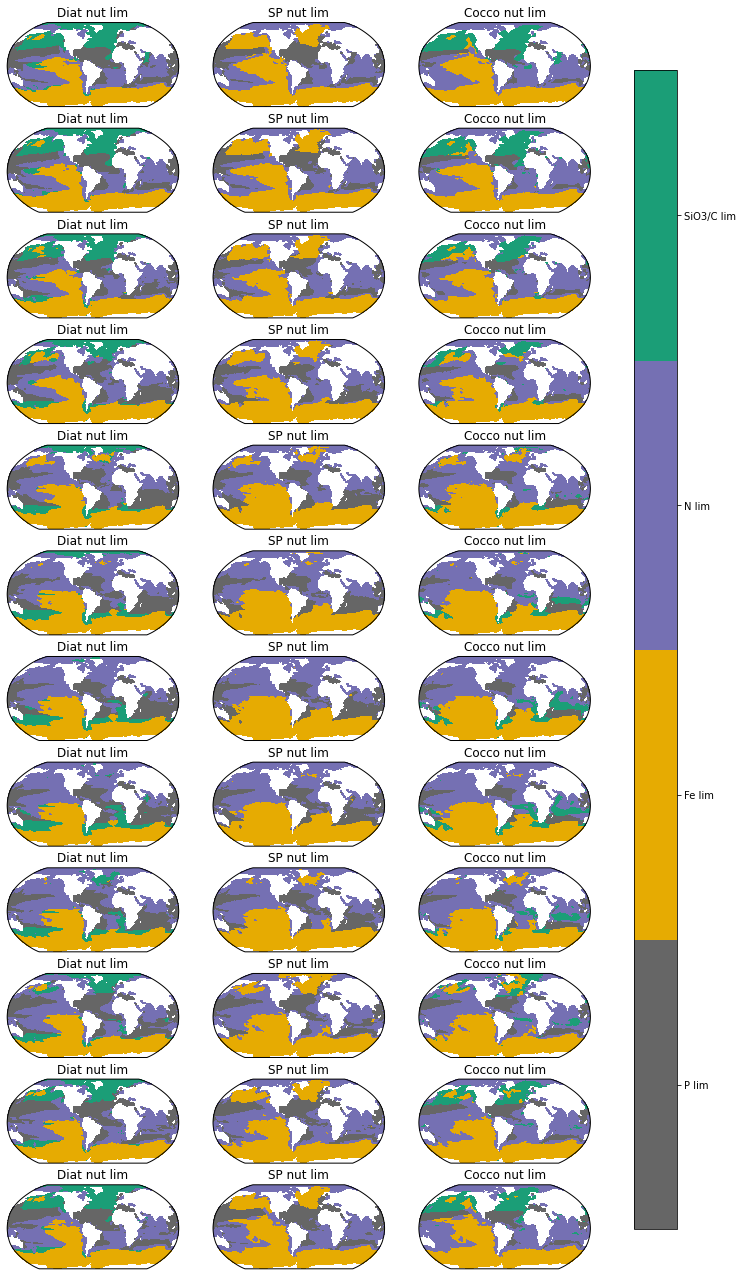

In [107]:
fig = plt.figure(figsize=(12,23))

for row in np.arange(1,13):
    ts=row-1
    
    plot = row*3 - 2
    
    #row 1 Jan
    ax = fig.add_subplot(12,3,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('Diat nut lim', fontsize=12)
    pc=ax.pcolormesh(lons, lats, most_lim_diat.isel(time=ts).where(~mask), cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
    colorbar_specs = {'ticks' : np.arange(0,4,1)}
    
    plot = row*3 - 1
    ax = fig.add_subplot(12,3,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('SP nut lim', fontsize=12)
    pc=ax.pcolormesh(lons, lats, most_lim_sp.isel(time=ts).where(~mask), cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
    colorbar_specs = {'ticks' : np.arange(0,4,1)}
    
    plot = row*3
    ax = fig.add_subplot(12,3,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('Cocco nut lim', fontsize=12)
    pc=ax.pcolormesh(lons, lats, most_lim_cocco.isel(time=ts).where(~mask), cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
    colorbar_specs = {'ticks' : np.arange(0,4,1)}

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,**colorbar_specs)
cbar.ax.set_yticklabels(['P lim', 'Fe lim', 'N lim','SiO3/C lim']);

### Look at phyto carbon pools

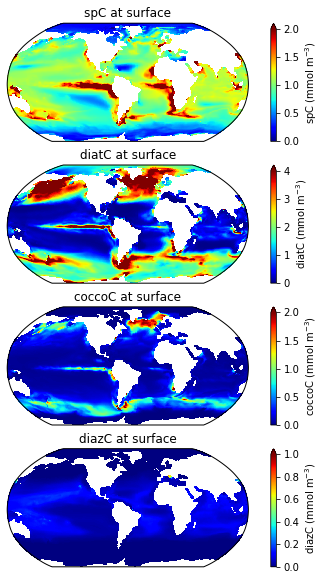

In [108]:
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('coccoC at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.coccoC.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='coccoC (mmol m$^{-3}$)')

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diatC at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.diatC.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=4,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diatC (mmol m$^{-3}$)')

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('spC at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.spC.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='spC (mmol m$^{-3}$)')

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diazC at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.diazC.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=1,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diazC (mmol m$^{-3}$)')

### Phytoplankton production maps

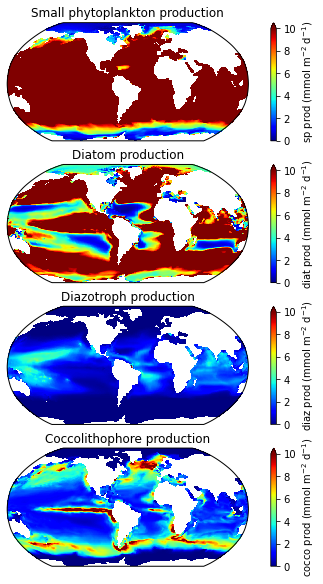

In [109]:
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Small phytoplankton production', fontsize=12)
tmp = cesm_ann_ds.photoC_sp_zint * 864.
pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=10,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='sp prod (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diatom production', fontsize=12)
tmp = cesm_ann_ds.photoC_diat_zint * 864.
pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=10,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diat prod (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diazotroph production', fontsize=12)
tmp = cesm_ann_ds.photoC_diaz_zint * 864.
pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=10,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diaz prod (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Coccolithophore production', fontsize=12)
tmp = cesm_ann_ds.photoC_cocco_zint * 864.
pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=10,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='cocco prod (mmol m$^{-2}$ d$^{-1}$)')

### Look at percent phytoC

In [110]:
phytoC = cesm_ann_ds.spC + cesm_ann_ds.diatC + cesm_ann_ds.diazC + cesm_ann_ds.coccoC
perc_sp = cesm_ann_ds.spC / (phytoC) * 100.
perc_cocco = cesm_ann_ds.coccoC / (phytoC) * 100.
perc_diat = cesm_ann_ds.diatC / (phytoC) * 100.
perc_diaz = cesm_ann_ds.diazC / (phytoC) * 100.

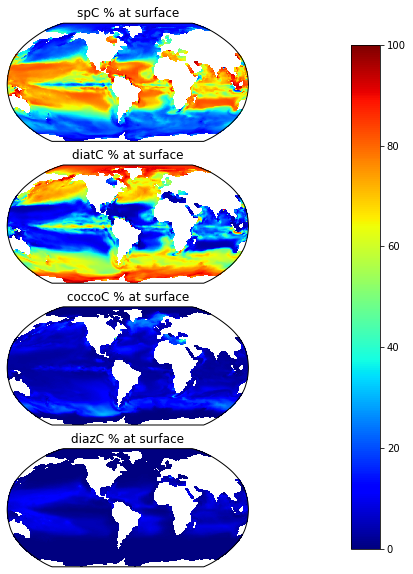

In [111]:
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('coccoC % at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, perc_cocco.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diatC % at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, perc_diat.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('spC % at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, perc_sp.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diazC % at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, perc_diaz.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(pc, cax=cbar_ax);

### Plot zooC

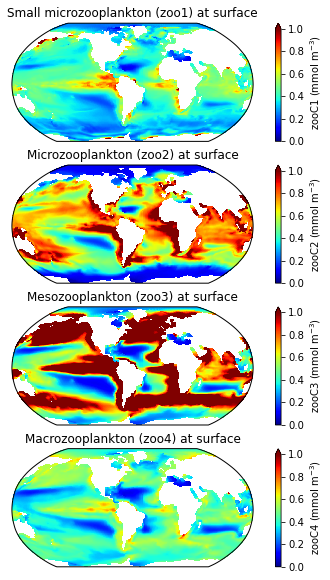

In [112]:
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Small microzooplankton (zoo1) at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.zoo1C.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=1,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='zooC1 (mmol m$^{-3}$)')

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Microzooplankton (zoo2) at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.zoo2C.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=1,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='zooC2 (mmol m$^{-3}$)')

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Mesozooplankton (zoo3) at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.zoo3C.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=1,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='zooC3 (mmol m$^{-3}$)')

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Macrozooplankton (zoo4) at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.zoo4C.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=1,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='zooC4 (mmol m$^{-3}$)')

In [113]:
zoo1_biomass= esmlab.weighted_sum(cesm_ann_ds.zoo1C, weights=area_m, dim=['nlat', 'nlon']).compute() #mmol/m
zoo1_biomass = zoo1_biomass * 10. #mmol
zoo1_biomass = zoo1_biomass.sum(dim='z_t_150m')
zoo1_biomass = zoo1_biomass.values * 0.001* 1.e-15 * 12.011 #Pg
print('zoo1 biomass is ', zoo1_biomass, ' Pg C.')
zoo2_biomass= esmlab.weighted_sum(cesm_ann_ds.zoo2C, weights=area_m, dim=['nlat', 'nlon']).compute() #mmol/m
zoo2_biomass = zoo2_biomass * 10. #mmol
zoo2_biomass = zoo2_biomass.sum(dim='z_t_150m')
zoo2_biomass = zoo2_biomass.values * 0.001* 1.e-15 * 12.011 #Pg
print('zoo2 biomass is ', zoo2_biomass, ' PgC')
print('Total microzooplankton biomass is estimated at 0.24 Pg C (Buitenhuis et al., 2010). Here it is ', zoo1_biomass + zoo2_biomass, ' Pg C.')
zoo3_biomass= esmlab.weighted_sum(cesm_ann_ds.zoo3C, weights=area_m, dim=['nlat', 'nlon']).compute() #mmol/m
zoo3_biomass = zoo3_biomass * 10. #mmol
zoo3_biomass = zoo3_biomass.sum(dim='z_t_150m')
zoo3_biomass = zoo3_biomass.values * 0.001* 1.e-15 * 12.011 #Pg
print('zoo3 biomass is ', zoo3_biomass, ' Pg C. Mesozooplankton biomass is estimated to be between 0.16 to 0.19 Pg C (Buitenhuis et al., 2006; Moriarty & OBrien, 2013)')
zoo4_biomass= esmlab.weighted_sum(cesm_ann_ds.zoo4C, weights=area_m, dim=['nlat', 'nlon']).compute() #mmol/m
zoo4_biomass = zoo4_biomass * 10. #mmol
zoo4_biomass = zoo4_biomass.sum(dim='z_t_150m')
zoo4_biomass = zoo4_biomass.values * 0.001* 1.e-15 * 12.011 #Pg
print('zoo4 biomass is ', zoo4_biomass, ' Pg C. Macrozooplankton biomass is estimated to be 0.02 Pg C (Moriarty et al., 2013).')

zoo1 biomass is  0.13380454939759  Pg C.
zoo2 biomass is  0.21283739483388575  PgC
Total microzooplankton biomass is estimated at 0.24 Pg C (Buitenhuis et al., 2010). Here it is  0.34664194423147576  Pg C.
zoo3 biomass is  0.2989205155002716  Pg C. Mesozooplankton biomass is estimated to be between 0.16 to 0.19 Pg C (Buitenhuis et al., 2006; Moriarty & OBrien, 2013)
zoo4 biomass is  0.18815207103880913  Pg C. Macrozooplankton biomass is estimated to be 0.02 Pg C (Moriarty et al., 2013).


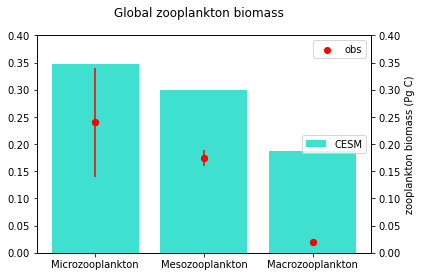

In [114]:
fig, ax = plt.subplots()
labels=['Microzooplankton','Mesozooplankton','Macrozooplankton']
ind=[0,1,2]
obs=[0.24,0.175,0.02]
obserr=[0.1,0.015,0]
vals=[zoo1_biomass + zoo2_biomass,zoo3_biomass,zoo4_biomass]

plt.suptitle('Global zooplankton biomass')
ax.bar(ind, vals,label='CESM',color='turquoise')
ax.legend(loc='center right')
ax.set_ylim(0,0.4)
ax2 = ax.twinx()
ax2.scatter(ind, obs,color='red',marker='o', label='obs')
ax2.errorbar(ind, obs,yerr=obserr,color='red',fmt='o')
ax2.set_ylim(0,0.4)
ax2.set_ylabel('zooplankton biomass (Pg C)')
ax2.legend()
plt.xticks(ind, labels,rotation=45, ha='right');

### Plot zooplankton production maps

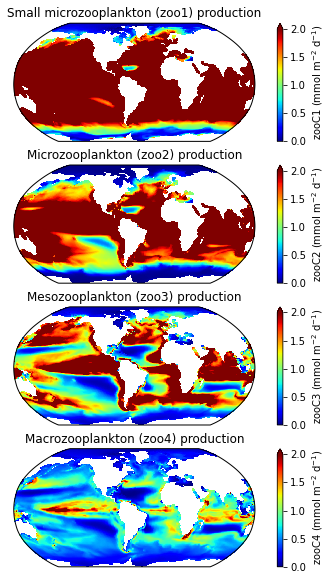

In [115]:
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Small microzooplankton (zoo1) production', fontsize=12)
tmp = cesm_ann_ds.x_graze_zoo1_zint * 864.
pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='zooC1 (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Microzooplankton (zoo2) production', fontsize=12)
tmp = cesm_ann_ds.x_graze_zoo2_zint * 864.
pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='zooC2 (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Mesozooplankton (zoo3) production', fontsize=12)
tmp = cesm_ann_ds.x_graze_zoo3_zint * 864.
pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='zooC3 (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Macrozooplankton (zoo4) production', fontsize=12)
tmp = cesm_ann_ds.x_graze_zoo4_zint * 864.
pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='zooC4 (mmol m$^{-2}$ d$^{-1}$)')

### NPP

In [116]:
nmols_to_PgCyr = 1e-9 * 12. * 1e-15 * 365. * 86400.

In [117]:
variables = [f'photoC_{phyto}_zint' for phyto in ['diat', 'sp', 'diaz', 'cocco', 'TOT']]

ds_glb = xr.Dataset()
for v in variables:
    ds_glb[v] = esmlab.statistics.weighted_sum(cesm_ann_ds[v], weights=area, dim=['nlat', 'nlon'])
    ds_glb[v].attrs = cesm_ann_ds[v].attrs

    #if ds1_annmean[v].units == 'mmol/m^3 cm/s':
    ds_glb[v] = ds_glb[v] * nmols_to_PgCyr        
    ds_glb[v].attrs['units'] = 'Pg C yr$^{-1}$'

ds_glb = ds_glb.compute()
ds_glb

<xarray.Dataset>
Dimensions:            ()
Data variables:
    photoC_diat_zint   float64 21.01
    photoC_sp_zint     float64 39.45
    photoC_diaz_zint   float64 1.812
    photoC_cocco_zint  float64 4.4
    photoC_TOT_zint    float64 66.67

### Zooplankton production (zoo grazing - zoo respiration)
#### Should be ~25% of NPP

In [118]:
variables = [f'x_graze_{zoo}_zint' for zoo in ['zoo1', 'zoo2', 'zoo3','zoo4']]

ds_zooglb = xr.Dataset()
for v in variables:
    ds_zooglb[v] = esmlab.statistics.weighted_sum(cesm_ann_ds[v], weights=area, dim=['nlat', 'nlon'])
    ds_zooglb[v].attrs = cesm_ann_ds[v].attrs

    #if ds1_annmean[v].units == 'mmol/m^3 cm/s':
    ds_zooglb[v] = ds_zooglb[v] * nmols_to_PgCyr        
    ds_zooglb[v].attrs['units'] = 'Pg C yr$^{-1}$'

ds_zooglb = ds_zooglb.compute()
ds_zooglb

<xarray.Dataset>
Dimensions:            ()
Data variables:
    x_graze_zoo1_zint  float64 8.429
    x_graze_zoo2_zint  float64 3.195
    x_graze_zoo3_zint  float64 2.569
    x_graze_zoo4_zint  float64 1.07

In [119]:
## calculate % zoo prod of NPP 
npp_tot=ds_glb.photoC_TOT_zint.values
zoo_prod=ds_zooglb.x_graze_zoo1_zint.values + ds_zooglb.x_graze_zoo2_zint.values + ds_zooglb.x_graze_zoo3_zint.values
print('• Zooplankton production is ', (zoo_prod/npp_tot * 100.), '% of NPP.')
## calculate % microzooplankton (zoo1) prod of total zoo prod
micro_prod=ds_zooglb.x_graze_zoo1_zint.values
print('• Small microzooplankton production is ', (micro_prod/zoo_prod * 100.), '% of total zooplankton production.')
micro_prod=ds_zooglb.x_graze_zoo1_zint.values + ds_zooglb.x_graze_zoo2_zint.values
print('• Microzooplankton production is ', (micro_prod/zoo_prod * 100.), '% of total zooplankton production.')
print('• Microzooplankton production is ', (micro_prod/npp_tot * 100.), '% of NPP.')

• Zooplankton production is  21.28837941946665 % of NPP.
• Small microzooplankton production is  59.3891034991791 % of total zooplankton production.
• Microzooplankton production is  81.90119812853986 % of total zooplankton production.
• Microzooplankton production is  17.435437806692686 % of NPP.


### Z-ratio (Stock & Dunne, 2010)

In [120]:
file='/glade/work/kristenk/z-ratio/z_ratio_POPgrid.nc'
ds_zratio=xr.open_dataset(file,decode_times=False,decode_coords=False)

In [121]:
z_ratio = cesm_ann_ds.x_graze_zoo3_zint / cesm_ann_ds.photoC_TOT_zint
z_ratio = (cesm_ann_ds.x_graze_zoo3_zint + cesm_ann_ds.x_graze_zoo4_zint) / cesm_ann_ds.photoC_TOT_zint

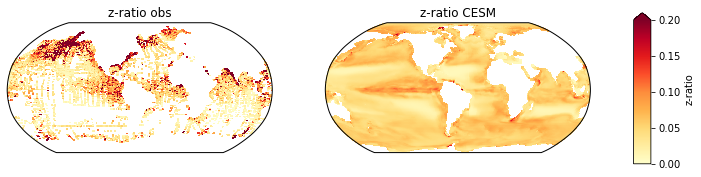

In [122]:
fig = plt.figure(figsize=(12,3))

ax = fig.add_subplot(1,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('z-ratio obs', fontsize=12)
tmp = ds_zratio.z_ratio
pc=ax.pcolormesh(lons, lats, tmp, cmap='YlOrRd',vmin=0,vmax=0.2,transform=ccrs.PlateCarree())

ax = fig.add_subplot(1,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('z-ratio CESM', fontsize=12)
tmp = z_ratio
pc=ax.pcolormesh(lons, lats, tmp, cmap='YlOrRd',vmin=0,vmax=0.2,transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='z-ratio')

### MAREDAT Micozooplankton/zoo1+zoo2 comparison

In [123]:
file = '/glade/work/kristenk/MAREDAT/microzooplankton/mean_fields/MAREDAT_microzoo_means.nc'
maredat_microzoo_ds=xr.open_dataset(file,decode_times=False,decode_coords=False)

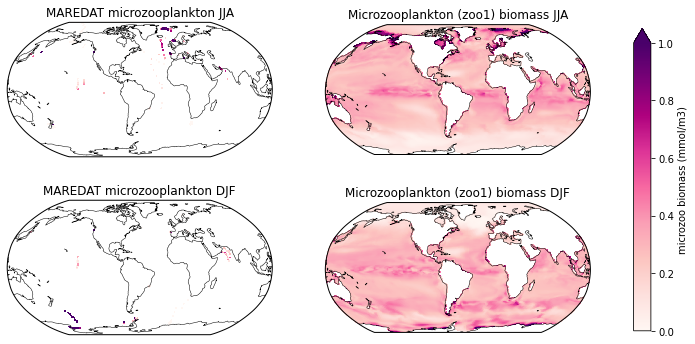

In [124]:
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(2,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('MAREDAT microzooplankton JJA', fontsize=12)
tmp = maredat_microzoo_ds.JJA_mean_top100m/12.011 #converting from mg/m3 to mmol/m3
pc=ax.pcolormesh(maredat_microzoo_ds.LONGITUDE, maredat_microzoo_ds.LATITUDE, tmp, cmap='RdPu',vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

ax = fig.add_subplot(2,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Microzooplankton (zoo1) biomass JJA', fontsize=12)
tmp = cesm_mon_ds.zoo1C.isel(time=[5,6,7],z_t_150m=slice(0,10)).mean(dim='z_t_150m').mean(dim='time')
tmp2 = cesm_mon_ds.zoo2C.isel(time=[5,6,7],z_t_150m=slice(0,10)).mean(dim='z_t_150m').mean(dim='time')
#tmp=tmp+tmp2
pc=ax.pcolormesh(lons, lats, tmp, cmap='RdPu',vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

ax = fig.add_subplot(2,2,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('MAREDAT microzooplankton DJF', fontsize=12)
tmp = maredat_microzoo_ds.DJF_mean_top100m/12.011 #converting from mg/m3 to mmol/m3
pc=ax.pcolormesh(maredat_microzoo_ds.LONGITUDE, maredat_microzoo_ds.LATITUDE, tmp, cmap='RdPu',vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

ax = fig.add_subplot(2,2,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Microzooplankton (zoo1) biomass DJF', fontsize=12)
tmp = cesm_mon_ds.zoo1C.isel(time=[11,0,1],z_t_150m=slice(0,10)).mean(dim='z_t_150m').mean(dim='time')
tmp2 = cesm_mon_ds.zoo2C.isel(time=[11,0,1],z_t_150m=slice(0,10)).mean(dim='z_t_150m').mean(dim='time')
#tmp = tmp + tmp2
pc=ax.pcolormesh(lons, lats, tmp, cmap='RdPu',vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max',label='microzoo biomass (mmol/m3)');

### COPEPOD comparison (Mesozooplankton/zoo3)

In [125]:
file = '/glade/u/home/kristenk/work/copepod-biomass/data/POP_gx1v7/copepod-2012__cmass-m00-qtr.zarr'
ds_copepod = xr.open_zarr(file)
ds_copepod['copepod_C']=ds_copepod.copepod_C/12.011

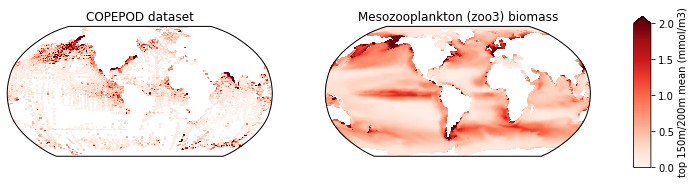

In [126]:
fig = plt.figure(figsize=(12,3))

ax = fig.add_subplot(1,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('COPEPOD dataset', fontsize=12)
tmp = ds_copepod.copepod_C
pc=ax.pcolormesh(lons, lats, tmp, cmap='Reds',vmin=0,vmax=2,transform=ccrs.PlateCarree())

ax = fig.add_subplot(1,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Mesozooplankton (zoo3) biomass', fontsize=12)
tmp = cesm_ann_ds.zoo3C.mean(dim='z_t_150m')
pc=ax.pcolormesh(lons, lats, tmp, cmap='Reds',vmin=0,vmax=2,transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='top 150m/200m mean (mmol/m3)')

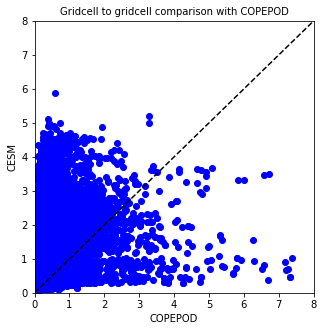

In [127]:
#### make line plots plotting mesozooplankton abundance versus COPEPOD database
one2one = np.array([0, 8])
x_vals = ds_copepod.copepod_C.values
x_vals = x_vals.flatten()

fig = plt.figure(figsize=(5,5))   
#set up the vals
y_vals = cesm_ann_ds.zoo3C.isel(z_t_150m=0).values
y_vals = y_vals.flatten()
ax = fig.add_subplot(1,1,1)
ax.scatter(x_vals,y_vals,color='blue',marker='o',
           label='control')
ax.set_ylabel('CESM')
ax.set_xlabel('COPEPOD')
ax.set_ylim(0,8)
ax.set_xlim(0,8)
ax.plot(one2one,one2one,color='black',linestyle='--')
ax.set_title('Gridcell to gridcell comparison with COPEPOD', fontsize=10);

### Macrozooplankton comparison

In [128]:
file = '/glade/work/kristenk/MAREDAT/macrozooplankton/mean_fields/MAREDAT_macrozoo_means.nc'
maredat_macrozoo_ds=xr.open_dataset(file,decode_times=False,decode_coords=False)

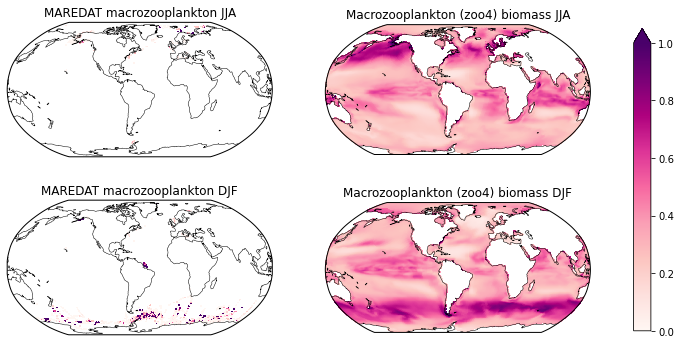

In [129]:
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(2,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('MAREDAT macrozooplankton JJA', fontsize=12)
tmp = maredat_macrozoo_ds.JJA_mean_top100m/12.011 #converting from mg/m3 to mmol/m3
pc=ax.pcolormesh(maredat_macrozoo_ds.LONGITUDE, maredat_macrozoo_ds.LATITUDE, tmp, cmap='RdPu',vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

ax = fig.add_subplot(2,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Macrozooplankton (zoo4) biomass JJA', fontsize=12)
tmp = cesm_mon_ds.zoo4C.isel(time=[5,6,7],z_t_150m=slice(0,10)).mean(dim='z_t_150m').mean(dim='time')
pc=ax.pcolormesh(lons, lats, tmp, cmap='RdPu',vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

ax = fig.add_subplot(2,2,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('MAREDAT macrozooplankton DJF', fontsize=12)
tmp = maredat_macrozoo_ds.DJF_mean_top100m/12.011 #converting from mg/m3 to mmol/m3
pc=ax.pcolormesh(maredat_macrozoo_ds.LONGITUDE, maredat_macrozoo_ds.LATITUDE, tmp, cmap='RdPu',vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

ax = fig.add_subplot(2,2,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Macrozooplankton (zoo4) biomass DJF', fontsize=12)
tmp = cesm_mon_ds.zoo4C.isel(time=[11,0,1],z_t_150m=slice(0,10)).mean(dim='z_t_150m').mean(dim='time')
pc=ax.pcolormesh(lons, lats, tmp, cmap='RdPu',vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max');

In [130]:
ifrac = cesm_mon_ds.IFRAC.isel(time=[11,0,1]).mean(dim='time') #.where(cesm_ann_ds.IFRAC > 0)

In [131]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

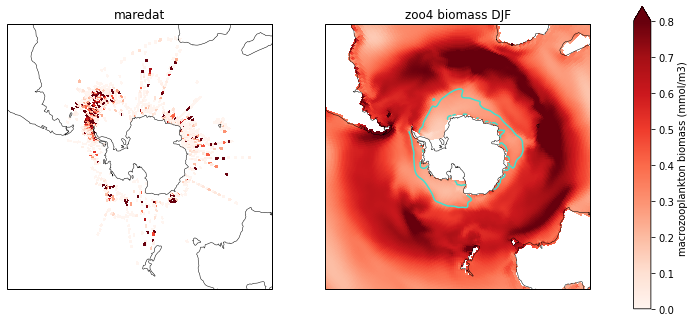

In [132]:
fig = plt.figure(figsize=(12,6))

# obs -----------------------------------------------------------------
ax = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
ax.set_title('maredat')
pc=ax.pcolormesh(maredat_macrozoo_ds.LONGITUDE, maredat_macrozoo_ds.LATITUDE, 
                 maredat_macrozoo_ds.DJF_mean_top100m/12.011, #converting from mg/m3 to mmol/m3
                 vmin=0, vmax=1, 
                 cmap='Reds',
                 transform=ccrs.PlateCarree())

########################
tmp = cesm_mon_ds.zoo4C.isel(time=[11,0,1],z_t_150m=slice(0,10)).mean(dim='z_t_150m').mean(dim='time')
lon,lat,field = adjust_pop_grid(lons, lats, tmp)

sh = lats[:, 0] < 0
lons_sh = lon[sh, :]
lats_sh = lat[sh, :]
field = field[sh, :]

lon,lat,field2 = adjust_pop_grid(lons, lats, ifrac)
lons_sh2 = lon[sh, :]
lats_sh2 = lat[sh, :]
field2 = field2[sh, :]

ax = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('zoo4 biomass DJF', fontsize=12)
pc=ax.pcolormesh(lons_sh, lats_sh, 
                 field, 
                 vmin=0, vmax=0.8, 
                 cmap='Reds',
                 transform=ccrs.PlateCarree())
pci=ax.contour(lons_sh2, lats_sh2, 
                 field2, 
                 levels=[0.1], 
                 colors='turquoise',
                 transform=ccrs.PlateCarree(), label='10% ice cover'
              )

ax.coastlines('110m',linewidth=0.5)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='macrozooplankton biomass (mmol/m3)');
# cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
# fig.colorbar(pci, cax=cbar_ax,extend='max', label='IFRAC');

### Calcification

In [133]:
## GLOBALLY integrated calcification; observation-based estimates range from 0.8 to 2.4 Pg CaCO3 per year 
## (Feely et al., 2004, Maranon et al., 2016, Smith et al., 2016, Balch et al., 2007, Iglesias-Rodriguez et al., 2002)
ds_glb['CaCO3_PROD_zint'] = esmlab.statistics.weighted_sum(cesm_ann_ds['CaCO3_PROD_zint'], weights=area, dim=['nlat', 'nlon'])
ds_glb['CaCO3_PROD_zint'] = ds_glb['CaCO3_PROD_zint'] * nmols_to_PgCyr
ds_glb['CaCO3_PROD_zint'].values
print('Globally integrated calcification is',ds_glb['CaCO3_PROD_zint'].values, 'Pg C per year')
print('(should be between 0.6 to 2.4 Pg C per year)')

Globally integrated calcification is 1.569095613937775 Pg C per year
(should be between 0.6 to 2.4 Pg C per year)


In [134]:
#read in mean PIC
pic_file = '/glade/work/kristenk/satellite_data/processed/PIC_mean2003to2018_1deg.nc'
ds_pic=xr.open_dataset(pic_file, decode_times=False)
#ds_pic.PIC

In [135]:
#convert to mmol/m3 from mg/m3
ds_pic['PIC']=ds_pic.PIC / 12.011

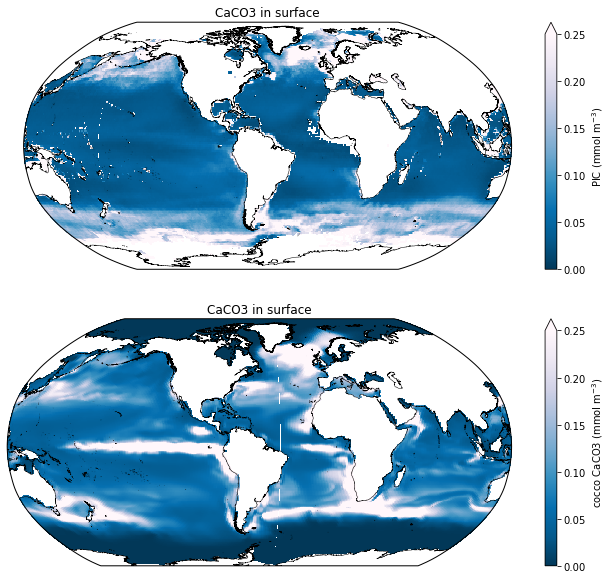

In [136]:
fig = plt.figure(figsize=(12,10))


ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CaCO3 in surface', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(ds_pic.lon.values, ds_pic.lat.values, ds_pic.PIC, cmap='PuBu_r',vmin=0,vmax=0.25,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='PIC (mmol m$^{-3}$)')

ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CaCO3 in surface', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.coccoCaCO3.isel(z_t_150m=0), cmap='PuBu_r',vmin=0,vmax=0.25,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='cocco CaCO3 (mmol m$^{-3}$)')


### cocco PIC/POC

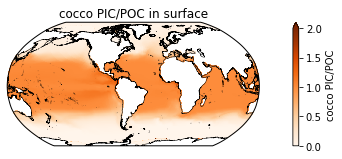

In [137]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('cocco PIC/POC in surface', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.coccoCaCO3.isel(z_t_150m=0)/cesm_ann_ds.coccoC.isel(z_t_150m=0), cmap='Oranges',vmin=0,vmax=2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='cocco PIC/POC')


### Alkalinity

In [138]:
#just getting this for the coords (that don't have nans)
file = '/glade/work/kristenk/GLODAPv2_regridded/glodap_pop_grid/GLODAP_POPgrid_v2.nc'
ds_glodap = xr.load_dataset(file, decode_times=False, decode_coords=False)
ds_glodap['z_t']=cesm_ann_ds.z_t

In [139]:
rmse_global['ALK']=esmlab.statistics.weighted_rmsd(cesm_ann_ds.ALK, ds_glodap.ALK, dim=['nlat', 'nlon'], weights=area)
rmse_global.ALK.values

array([45.83555794, 40.76245273, 39.31937436, 35.63853124, 34.99302602,
       21.2664131 , 20.51011813, 20.4598513 , 19.52757964, 18.21277116,
       18.09619832, 17.79563038, 17.80032527, 17.30362575, 17.04659632,
       16.65327692, 16.14934818, 15.80758654, 15.58499659, 15.51657402,
       14.96606625, 14.47309132, 14.0918523 , 13.86137266, 13.48892519,
       13.31891206, 13.26297629, 12.97709834, 12.83624147, 12.91465816,
       13.12540007, 13.03282394, 13.2856892 , 13.30937469, 13.29962827,
       12.99494716, 12.69287969, 11.99416493, 11.26995464, 10.65695292,
        9.88460332,  8.87778176,  7.66704508,  6.81128812,  6.56660529,
        6.44074845,  6.20253363,  6.58013555,  6.73400997,  7.00841629,
        7.03994657,  7.4150704 ,  7.75888632,  8.64393914,  8.87432979,
       10.05539669, 11.61050747, 13.13484651, 12.34706344, 13.36574802])

In [140]:
ALK_diff = cesm_ann_ds.ALK - ds_glodap.ALK

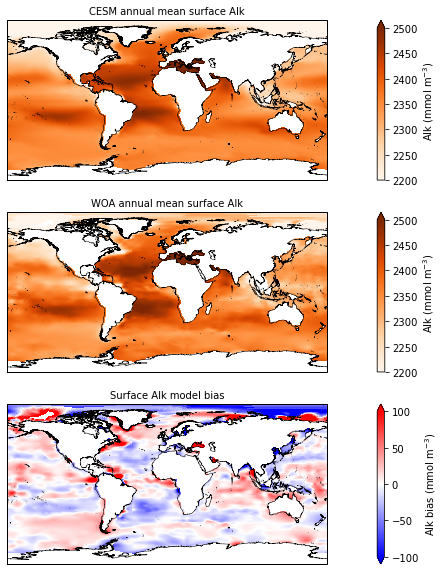

In [141]:
#plot surface alkalinity

fig = plt.figure(figsize=(18,10))

####################NO3
#COLUMN 1  - NO3
#---- CESM panel
ax = fig.add_subplot(3,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface Alk', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 cesm_ann_ds.ALK.isel(z_t=0), cmap='Oranges',
                  vmin=2200, vmax=2500, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='Alk (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,1,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface Alk', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_glodap.ALK.isel(z_t=0), cmap='Oranges',
                  vmin=2200, vmax=2500, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='Alk (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,1,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface Alk model bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 ALK_diff.isel(z_t=0), vmin=-100, vmax=100, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='Alk bias (mmol m$^{-3}$)')

### Global POC export

In [142]:
ds_glb['POC_FLUX_100m'] = esmlab.statistics.weighted_sum(cesm_ann_ds['POC_FLUX_100m'], weights=area, dim=['nlat', 'nlon'])
ds_glb['POC_FLUX_100m'] = ds_glb['POC_FLUX_100m'] * nmols_to_PgCyr
ds_glb['POC_FLUX_100m'].values
print('Globally integrated POC flux is',ds_glb['POC_FLUX_100m'].values, 'Pg C per year')

Globally integrated POC flux is 8.119420395240159 Pg C per year
